In the Week 4 the instructor is mainly speaking about metrics for evaluating how good a model is, and their drawbacks. By the names of the videos I can see that it is going to be mainly about classification metrics, since I'm already familiar with them. 

We will start off by importing necessary libraries and put the code necesarry just for training the model on which we obtained accuracy of 80%. Refer to details in ```validation-framework.ipynb```. 

In [1]:
#Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

from collections import Counter

In [2]:
#Data munging is already done, and the data is extracted in 'data-preparation.csv' 
#so I will just import the already prepared data.

RANDOM_STATE = 42
df = pd.read_csv('./data/data-preparation.csv')

df.head()

,customerid,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,onlinesecurity,...,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,totalcharges,churn
0,7590-vhveg,female,0,yes,no,1,no,no_phone_service,dsl,no,...,no,no,no,no,month-to-month,yes,electronic_check,29.85,29.85,0
1,5575-gnvde,male,0,no,no,34,yes,no,dsl,yes,...,yes,no,no,no,one_year,no,mailed_check,56.95,1889.50,0
2,3668-qpybk,male,0,no,no,2,yes,no,dsl,yes,...,no,no,no,no,month-to-month,yes,mailed_check,53.85,108.15,1
3,7795-cfocw,male,0,no,no,45,no,no_phone_service,dsl,yes,...,yes,yes,no,no,one_year,no,bank_transfer_(automatic),42.30,1840.75,0
4,9237-hqitu,female,0,no,no,2,yes,no,fiber_optic,no,...,no,no,no,no,month-to-month,yes,electronic_check,70.70,151.65,1


In [3]:
#Splitting the data
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=RANDOM_STATE)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=RANDOM_STATE)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.churn.values
y_val = df_val.churn.values
y_test = df_test.churn.values

del df_train['churn']
del df_val['churn']
del df_test['churn']

In [4]:
#Assesing categorical vs numerical variables
numerical = ['tenure', 'monthlycharges', 'totalcharges']

categorical = [
    'gender',
    'seniorcitizen',
    'partner',
    'dependents',
    'phoneservice',
    'multiplelines',
    'internetservice',
    'onlinesecurity',
    'onlinebackup',
    'deviceprotection',
    'techsupport',
    'streamingtv',
    'streamingmovies',
    'contract',
    'paperlessbilling',
    'paymentmethod',
]

I think here it is worth mentioning that in the previous notebook we've trained on ```df_train_full``` at the very end, but that is the step AFTER tuning our model on validation data and since validation data is used for assesing model performance (as I call it *playground*) we have to take a step back in the Data Science process and work from there. 

That is why we are training on ```df_train```. 

In [5]:
#Preparing the data for model by doing OHE...
dv = DictVectorizer(sparse=False)

#...and training the Logistic Regression model
train_dict = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

model = LogisticRegression(solver='liblinear', random_state=RANDOM_STATE)
model.fit(X_train, y_train)

LogisticRegression(random_state=42, solver='liblinear')

Remember, last time that we spoke a bit on *cut-off probability*. Once the model learned weights and bias term we gave it validation data as input and obtained probabilities that the model infered on that data.

We said explicitly that cut-off probability is 0.5 (which is a default one for Logistic Regression) and we said that everything above that probability will be considered as **customer will churn** (we will put 1 there), while conversely everything lower than that would mean **the customer wont churn** (we will put 0 there).
And, we obtained those *hard predictions* and put them in a NumPy array ```churn_decision```. 

Here is the code for that:

In [6]:
val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)

y_pred = model.predict_proba(X_val)[:, 1]
churn_decision = (y_pred >= 0.5)

In [7]:
type(churn_decision)

numpy.ndarray

So, what are the potential drawbacks on this? Well, we are lucky enough to know there are ground truths for churning in the validation data (```y_val```), and we can compare them with the 'hard predictions' we assesed using 0.5 as a cut-off probability (```churn_decision```). Pay close attention to **compare them**. 

Don't fall into trap thinking 'it is only for churned customers'. No, by using 0.5 as a cut-off probability we are also assesing predictions for the customers that didn't churn. We don't want model to just predict good on those who will churn, or only on those who wont. We want a well-rounded model. We put the money in knowing that model as *a decision maker* will serve us well for both. I want to send a promotional email for those who are willing to churn, not loose money on those who wont. They are satisfied! 

Here is a DataFrame I've created previously to get a better picture of what I'm trying to say:

In [8]:
#Creating a dataframe containing all the info we need
df_pred = pd.DataFrame()
df_pred['probability'] = y_pred
df_pred['actual'] = y_val
df_pred['prediction'] = churn_decision.astype(int)
df_pred['correct'] = df_pred.prediction == df_pred.actual

df_pred.tail(10)

,probability,actual,prediction,correct
1399,0.070878,0,0,True
1400,0.681527,1,1,True
1401,0.629268,0,1,False
1402,0.035397,0,0,True
1403,0.060248,0,0,True
1404,0.067729,1,0,False
1405,0.315531,0,0,True
1406,0.713464,1,1,True
1407,0.050559,0,0,True
1408,0.036023,0,0,True


So, given a cut-off probability of 0.5, here is how accurate our model is on assesing both customers who will and those who won't churn:

In [9]:
df_pred.correct.mean()

0.8034066713981547

We see that there are mistakes, and the model is mistaking only 20% of a time. Here is a filtered DataFrame for mistakes only.

In [10]:
df_pred[df_pred['correct'] == False].head(10)

,probability,actual,prediction,correct
2,0.435661,1,0,False
10,0.629899,0,1,False
13,0.569593,0,1,False
15,0.704182,0,1,False
16,0.665806,0,1,False
20,0.165914,1,0,False
26,0.508863,0,1,False
29,0.183885,1,0,False
32,0.170327,1,0,False
34,0.046092,1,0,False


Imagine for a moment what would happen on these 10 rows of data if we said that the cut-off probability is >=0.2. How many of them would be **now** correctly classified by our model? Now play with that idea and think what would happen if we changed ```churn_decision = (y_pred >= 0.5)``` to ```churn_decision = (y_pred >= 0.1)``` on **the whole validation dataset** not just this sample of 10 rows? What would be the accuracy? Think of the edge cases 'what if we said cut-off to be >=0, >0, >=1'? Now, play with the different values of cut-off frequency and asses the accuracy. 

This will also teach you how to explore/tweak the code already written, how to start small and work your way up to a generalization. I think it is also a very useful skill to have under your belt!

Finally, you will realize *'There has to be a better way instead of playing with them. I know maths. I know how to visualize graphs.'*

In [11]:
thresholds = [round(element, 3) for element in np.linspace(0, 1, 21)]

scores = []
for t in thresholds:
    score = accuracy_score(y_val, y_pred >= t)
    scores.append(round(score,4))

thr_accuracy_dict = dict(zip(thresholds, scores))

thr_with_max_accuracy = max(thr_accuracy_dict, key=thr_accuracy_dict.get)

In [12]:
def plotting_threshold_vs_accuracy(cut_off = thr_with_max_accuracy):    
    '''
        By default it will graph threshold vs accuracy and the point of inflection will be seen as two lines
        (horizontal and vertical) intercepting. That is the point where the threshold gives best accuracy score.

    '''
    # Plotting the graph
    plt.plot(thresholds, scores, label='Accuracy')
    plt.xlabel('Threshold')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs. Threshold')

    # Add a vertical line at a specific threshold (for example, threshold=0.5)
    plt.axvline(x=cut_off, color='red', linestyle='--', label=f'Threshold = {cut_off}')
    plt.legend()

    # Add a horizontal line at the accuracy value corresponding to the chosen threshold
    chosen_accuracy = accuracy_score(y_val, y_pred >= cut_off)
    plt.axhline(y=chosen_accuracy, color='green', linestyle='--', label=f'Accuracy = {chosen_accuracy:.4f}')
    plt.legend()

    # Show the plot
    return plt.show()

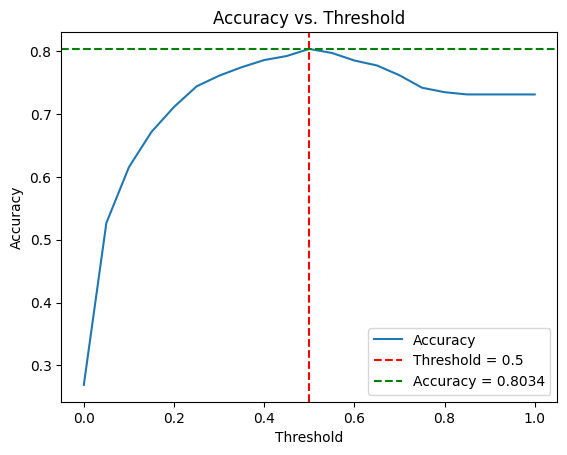

In [13]:
plotting_threshold_vs_accuracy()

We could eyeball that the accuracy score is the best around ```cut-off == 0.5``` and in the words of instructor *'```LogisticRegression()``` is optimizing for that cut-off already'*, but it is never bad to check it either via graph to get a representation of *all* the possibilities or like we've done it via code.

---

Now comes the concept of *Dummy Model*. Why would it be called *dummy*? Here is my interpretation of it. 

Apart from point on an x-axis (threshold) that gives us best accuracy score, there exist two more points that have much of an interest for us. Those are points where ```threshold = 1``` and ```threshold = 0```.

Think what would mean if we said 'for all the probability predictions where ```probability = cut_off >= 1``` say that customer churned'. I rarely saw that model is so damn sure about a prediction, and even if it is the case sigmoid is asympthotically aproaching 1. Could be due to very unlikely event, or synthetically putting row which for given weights and bias gives the result close to 1. 

But even without that, given that ```cut-off=1``` then model predicts that all people never churned, because all other probabilities are <=1. Do you think the accuracy would be 0? Let's take a look!

In [14]:
churn_decision = (y_pred >= 1)
df_pred = pd.DataFrame()
df_pred['probability'] = y_pred
df_pred['actual'] = y_val
df_pred['prediction'] = churn_decision.astype(int)
df_pred['correct'] = df_pred.prediction == df_pred.actual

df_pred.head(10)

,probability,actual,prediction,correct
0,0.167199,0,0,True
1,0.253132,0,0,True
2,0.435661,1,0,False
3,0.562363,1,0,False
4,0.049742,0,0,True
5,0.125869,0,0,True
6,0.377995,0,0,True
7,0.013390,0,0,True
8,0.063902,0,0,True
9,0.147764,0,0,True


No, it would give the accuracy of 73%, because 73% of our validation data has **actual value** of ```churn == 0``` (Remember, we are calculating mean on the ```correct``` column!). 
73% of our validation dataset contains people that didn't churned, and 100%-73%=27% is the percentage of people who actually churned. 

In [15]:
df_pred.correct.mean()

0.7310149041873669

Why would we ever use a model which for every input predicts that nobody will churn? That model would never find out those who WILL potentially churn and we need to keep them and send them a promotional email! Why would we even bother training a model for such matter in a first place? We could make a decision 'nobody will churn, just relax and chill'. But, what is the point in that? 

That is why it is called *a Dummy Model*. We could done everything without ever using ML. 

But another question arises, why would we train the best model which gives us 80% accuracy, but a 'dummy model' gives us accuracy of 73% which is 7% in difference? That is why the accuracy metric is not so good with assesing imbalanced datasets. If we had balanced dataset (50% churn, 50% no churn) then the difference between model who gives accuracy of 80% and *dummy model* who gives 50% would be significant!

Dummy model of 'predicting that no customer will churn' is even better than Random Classifier which you can imagine as one which for each row in a dataset will toss a fair coin and decide if the customer would churn (heads) of not (tails). After you finish with all the coin tosses you will see that Random Classifier still gives around ~50% churned and ~50% didn't churned. 

Let's do some basic stats experiment to test that assumption!

In [16]:
import random


def coin_toss(weight_heads, weight_tails):
    
    '''
        Define a coin_toss function which will serve us as a proxy for tossing the real one.
    '''
    
    # Define the choices and their weights
    choices = ['Heads', 'Tails']
    weights = [weight_heads, weight_tails]
    
    # Perform the coin toss
    result = random.choices(choices, weights)[0]
    
    return result

In [17]:
#Let's test our function by setting the weights for 'Heads' and 'Tails' to be a fair toss
weight_heads = 50
weight_tails = 50

#Perform a simple coin toss
toss_result = coin_toss(weight_heads, weight_tails)

#Print the result
print(f"The result of the coin toss is: {toss_result}.")

The result of the coin toss is: Tails


Now, we will strip the ```df_pred``` which contains all the predictions for validation dataset and it's actual values. We only need ```probability``` and ```actual``` as columns.

In [18]:
df_coin_toss = df_pred[['probability', 'actual']].copy()
df_coin_toss.head()

,probability,actual
0,0.167199,0
1,0.253132,0
2,0.435661,1
3,0.562363,1
4,0.049742,0


Next, we are going to use ```coin_toss``` function which will for each row artificially toss a coin and populate the column ```coin_toss_result``` with either 'Heads' or 'Tails'. 
Then we are going to create a new column ```is_heads``` which will give us 1 if the result is 'Heads' or 0 if the result is 'Tails'. It will serve us in such a way that we can compare the results with the column ```actual``` like we did similarly whilst defining the cut-off probability.

Finally, we are going to compare ```actual``` with ```is_heads```.

In [19]:
df_coin_toss['coin_toss_result'] = df_coin_toss.apply(lambda row: coin_toss(weight_heads=50, weight_tails=50), axis=1)
df_coin_toss['is_heads'] = df_coin_toss['coin_toss_result'].apply(lambda result: 1 if result == 'Heads' else 0)
df_coin_toss['correct'] = df_coin_toss.actual == df_coin_toss.is_heads

In [20]:
df_coin_toss.head()

,probability,actual,coin_toss_result,is_heads,correct
0,0.167199,0,Heads,1,False
1,0.253132,0,Heads,1,False
2,0.435661,1,Heads,1,True
3,0.562363,1,Tails,0,False
4,0.049742,0,Tails,0,True


Now, a random process is a random process so don't expect to have exact 50% of 'Heads' and 'Tails'.

Here is the 'accuracy' of our Random Classifier:

In [23]:
df_coin_toss.correct.mean()

0.5166784953867991

Finally, let's *prove* that on average you should obtain nearly 50% for such result.

In [33]:
results = []
no_of_runs = 100

for i in range(no_of_runs):
    
    ##### This is our experiment
    df_coin_toss['coin_toss_result'] = df_coin_toss.apply(lambda row: coin_toss(weight_heads=50, weight_tails=50), axis=1)
    df_coin_toss['is_heads'] = df_coin_toss['coin_toss_result'].apply(lambda result: 1 if result == 'Heads' else 0)
    df_coin_toss['correct'] = df_coin_toss.actual == df_coin_toss.is_heads
    #####
    
    results.append(df_coin_toss.correct.mean())
    
print(f'Here is the average: {round(np.mean(results),4)}.')

Here is the average: 0.4999.


Increase the number of times this experiment runs by modifying ```no_of_runs``` and it will asymtotically get to 50%.

---

What about a model that has ```cut-off>=0```? Well, think of it. We have an unbalanced dataset with 27% of customers that churned. If we predicted that everyone churned, then we would be right only 27% of time. That is also the lowest possible accuracy we can have. Yes, we found all the True Positives but think of giving 73% of people email promotion of 25% discount. It is not going to impress your CEO at all. The model is even worse than previously discussed Random Classifier, and it could also be a decision which doesn't need ML at all. 